<a href="https://colab.research.google.com/github/kokikudo/submit_an_assignment/blob/master/Sprint5_Scratch_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVMスクラッチ
SVMには学習時に分類の間違いを認めるソフトマージンSVMと、認めないハードマージンSVMがありますが、ここでは実装が単純なハードマージンSVMを扱う。

In [ ]:
import importlib

In [ ]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル

    """
    def __init__(self,
                 num_iter=5000,
                 lr=1e-2,
                 kernel='liner',
                 d=1,
                 threshold=1e-5,
                 verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.d = d
        self.threshold = threshold
        self.verbose = verbose

    # 線形カーネル
    def _liner_kernel(self, X, i, j):
        return X[i].T @ X[j]

    # 多項式カーネル
    def _polynomial_kernel(self, X, i, j):
        return (1 * (X[i].T @ X[j]) + 0)**self.d

    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """

        self.lamda = np.random.rand(X.shape[0])

        # カーネル設定
        if self.kernel == 'liner':
            kernel = self._liner_kernel
        if self.kernel == 'polynomial':
            kernel = self._polynomial_kernel

        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            for k in range(self.iter):
                self._gradieny_ascent(X, y, kernel)
                print('---------------------------------------')
                print('n_iter:', k, 'lamda:', self.lamda)
        for k in range(self.iter):
            self._gradieny_ascent(X, y, kernel)

        # サポートベクターの選定
        self.index_support_vectors = np.where(self.lamda > self.threshold)
        self.n_support_vectors = len(X[self.index_support_vectors])
        self.X_sv = X[self.index_support_vectors]
        self.lam_sv = self.lamda[self.index_support_vectors]
        self.y_sv = y[self.index_support_vectors]
        print('閾値：', self.threshold)
        print('サポートベクター（候補）: 個数', self.n_support_vectors, '\n',
              X[self.index_support_vectors])

    def _gradieny_ascent(self, X, y, kernel):
        lamda = self.lamda
        #lamda_list = np.array([])
        for i in range(len(X)):
            discent = 0
            for j in range(len(X)):
                discent += self.lamda[j] * y[i] * y[j] * kernel(X, i, j)
            #lamda_list = np.append(lamda_list, discent)
            discent = lamda[i] + self.lr * (1 - discent)
            self.lamda[i] = np.maximum(0, discent)

        #self.lamda = lamda + self.lr * (1 - lamda_list)

    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。
        
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        x = X
        N = self.n_support_vectors
        n = self.index_support_vectors
        lamda_n = self.lam_sv
        ysv_n = self.y_sv
        s_n = self.X_sv
        if self.kernel == 'liner':
            pred_kernel = x @ s_n.T
        if self.kernel == 'polynomial':
            pred_kernel = (1 * (x @ s_n.T) + 0)**self.d

        # 推定開始
        pred_y = lamda_n * ysv_n * pred_kernel
        pred_y = np.sum(pred_y, axis=1)
        pred_y = pred_y / abs(pred_y)
        pred_y = pred_y.astype(int)

        return pred_y

## 【問題1】ラグランジュの未定乗数法による最急降下
SVMの学習は、ラグランジュの未定乗数法を用います。サンプル数分のラグランジュ乗数 λ
 を用意して、以下の式により更新していきます。この計算を行うメソッドをScratchSVMClassifierクラスに実装してください。
 
 $$
 \lambda_i^{new} = \lambda_i + \alpha(1 - \sum_{j=1}^{n}{\lambda_j y_i y_j k(x_i, x_j)})
 $$
 
 ここで $k(xi,xj)$ はカーネル関数です。線形カーネルの場合は次のようになります。他のカーネル関数にも対応できるように、この部分は独立したメソッドとしておきましょう。
 
 $$
 k(x_i, x_j) = x_{i}^{T} x_j
 $$
 
 条件として、更新毎に 
$$λ
i
>=
0$$
を満たす必要があります。満たさない場合は 
$$λ
i
=
0$$
とします。

$i,j$ : サンプルのインデックス

$λnewi$ : 更新後のi番目のサンプルのラグランジュ乗数

$λi$ : 更新前のi番目のサンプルのラグランジュ乗数

$α$ : 学習率

$λj$ : j番目のサンプルのラグランジュ乗数

$yi$ : i番目のサンプルのラベル

$yj$ : j番目のサンプルのラベル

$xi$ : i番目のサンプルの特徴量ベクトル

$xj$ : j番目のサンプルの特徴量ベクトル


あるサンプルに対しての全てのサンプルとの関係を計算していくことになります。



In [ ]:
import numpy as np

In [ ]:
# シンプルデータセット1
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))
simpleX = np.concatenate((f0, f1))
simpley = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)
random_index = np.random.permutation(np.arange(n_samples))
simpleX = simpleX[random_index]
simpley = simpley[random_index]

In [ ]:
# シンプルデータ1を5個抽出
small_X = simpleX[:5]
small_X

array([[ 0.77238275, -2.29167329],
       [-0.59334945,  1.66788336],
       [-2.0764856 ,  0.48746845],
       [ 0.11922688,  3.62537974],
       [-3.13000578, -0.15673155]])

In [ ]:
small_y = simpley[:5]
small_y

array([-1,  1,  1,  1,  1])

In [ ]:
# ラムダをとりあえず用意
lamda = np.random.rand(small_X.shape[0])
lamda

array([0.78078852, 0.64849689, 0.12651209, 0.86002657, 0.6180731 ])

In [ ]:
for i in range(len(small_X)):
    discent = 0
    for j in range(len(small_X)):
        discent += lamda[j] * small_y[i] * small_y[j] * (small_X[i].T @ small_X[j])
    new = discent
    print(new)

16.024761206900695
11.759047623560367
9.30316575948352
21.216719786872062
8.715391684451376


In [ ]:
lamda_list = np.array([])
for i in range(len(small_X)):
    discent = 0
    for j in range(len(small_X)):
        discent += lamda[j] * small_y[i] * small_y[j] * (small_X[i].T @ small_X[j])
    lamda_list = np.append(lamda_list, discent)
print(lamda_list)

[16.02476121 11.75904762  9.30316576 21.21671979  8.71539168]


In [ ]:
alpha = 1e-2
new_lamda = lamda + alpha * (1 - lamda_list)
new_lamda

array([0.63054091, 0.54090642, 0.04348043, 0.65785937, 0.54091919])

In [ ]:
test1 = ScratchSVMClassifier()
test1.fit(small_X, small_y)
test1.lamda

閾値： 1e-05
サポートベクター（候補）: 個数 2 
 [[-0.59334945  1.66788336]
 [-2.0764856   0.48746845]]


array([0.        , 0.24856807, 0.10806832, 0.        , 0.        ])

とりあえず動いた。

## 【問題2】サポートベクターの決定
計算したラグランジュ乗数 λ
 が設定した閾値より大きいサンプルをサポートベクターとして扱います。推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。


閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。

In [ ]:
# クラス外で試す
threshold = 1e-5
print('閾値：', threshold)

sup_index = test1.lamda > threshold

print('サポートベクター（候補）: 個数', len(small_X[sup_index]),'\n',  small_X[sup_index])

閾値： 1e-05
サポートベクター（候補）: 個数 2 
 [[-0.59334945  1.66788336]
 [-2.0764856   0.48746845]]


In [ ]:
# クラスに入れて試す
test2 = ScratchSVMClassifier()
test2.fit(small_X, small_y)

閾値： 1e-05
サポートベクター（候補）: 個数 2 
 [[-0.59334945  1.66788336]
 [-2.0764856   0.48746845]]


In [ ]:
# 元のサンプル数で試す
test2 = ScratchSVMClassifier(num_iter=10)
test2.fit(simpleX, simpley)

閾値： 1e-05
サポートベクター（候補）: 個数 7 
 [[ 0.46861035  2.21584467]
 [-0.95596327  1.07243091]
 [ 1.54634728 -1.21380311]
 [ 1.29767058 -0.64553225]
 [ 2.16044089 -0.14970841]
 [ 1.24814437 -2.16798041]
 [ 0.31731679  2.22551981]]


## 【問題3】推定
推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた 
$f(x)$の符号が分類結果です。

$$
f(x) = \sum_{n=1}^{N}\lambda_n y_{sv\_n} k(x, s_n)
$$

$x$
 : 推定したいデータの特徴量ベクトル


$N$
 : サポートベクターの数


$n$
 : サポートベクターのインデックス


$λn$ : n
番目のサポートベクターのラグランジュ乗数

$ysv_n$
 : 
n
番目のサポートベクターのラベル

$k()$
 : カーネル関数

$s_n$
 : 
n
番目のサポートベクターの特徴量

In [ ]:
test3 = ScratchSVMClassifier(num_iter=10)
test3.fit(simpleX, simpley)

閾値： 1e-05
サポートベクター（候補）: 個数 11 
 [[ 3.99770982  1.25164011]
 [-2.69336749 -0.61318911]
 [-1.02829008  0.23898594]
 [ 3.97475019  1.52122485]
 [ 2.42340322  0.48692572]
 [ 2.23162545  0.38441708]
 [ 2.71714245  0.98076082]
 [ 2.49174927  0.2780935 ]
 [-2.61058479  0.73924664]
 [ 0.31731679  2.22551981]
 [ 1.10298263 -0.54852515]]


In [ ]:
# クラス外でためす
x = simpleX
N = test3.n_support_vectors
n = test3.index_support_vectors
lamda_n = test3.lamda[n]
ysv_n = simpley[n]
s_n = simpleX[n]
kernel = x @ s_n.T

pred_y = lamda_n*ysv_n*kernel
pred_y = np.sum(pred_y, axis=1)
pred_y = pred_y / abs(pred_y)
pred_y = pred_y.astype(int)

pred_y

array([-1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1,  1,  1, -1,  1,  1,  1,
       -1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1,  1,  1, -1,
        1,  1,  1,  1, -1, -1,  1, -1, -1,  1, -1, -1,  1,  1,  1, -1, -1,
        1,  1,  1,  1, -1,  1,  1,  1, -1, -1,  1,  1,  1, -1,  1, -1, -1,
       -1, -1, -1,  1, -1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1, -1,  1,
       -1, -1,  1,  1, -1, -1,  1,  1, -1,  1,  1,  1, -1,  1, -1, -1, -1,
        1, -1,  1,  1, -1, -1,  1, -1, -1, -1,  1, -1,  1, -1, -1,  1,  1,
        1,  1,  1, -1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1,  1,
       -1,  1, -1, -1, -1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1,
        1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1, -1, -1,  1, -1, -1, -1,
       -1, -1, -1,  1,  1,  1, -1, -1,  1, -1, -1,  1, -1, -1,  1, -1, -1,
        1,  1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1,  1, -1,
       -1, -1,  1,  1,  1, -1, -1,  1,  1, -1, -1,  1, -1, -1,  1,  1, -1,
        1,  1, -1,  1,  1

In [ ]:
# クラスの中で試す
y_pred = test3.predict(simpleX, simpley)
y_pred

array([-1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1,  1,  1, -1,  1,  1,  1,
       -1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1,  1,  1, -1,
        1,  1,  1,  1, -1, -1,  1, -1, -1,  1, -1, -1,  1,  1,  1, -1, -1,
        1,  1,  1,  1, -1,  1,  1,  1, -1, -1,  1,  1,  1, -1,  1, -1, -1,
       -1, -1, -1,  1, -1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1, -1,  1,
       -1, -1,  1,  1, -1, -1,  1,  1, -1,  1,  1,  1, -1,  1, -1, -1, -1,
        1, -1,  1,  1, -1, -1,  1, -1, -1, -1,  1, -1,  1, -1, -1,  1,  1,
        1,  1,  1, -1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1,  1,
       -1,  1, -1, -1, -1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1,
        1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1, -1, -1,  1, -1, -1, -1,
       -1, -1, -1,  1,  1,  1, -1, -1,  1, -1, -1,  1, -1, -1,  1, -1, -1,
        1,  1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1,  1, -1,
       -1, -1,  1,  1,  1, -1, -1,  1,  1, -1, -1,  1, -1, -1,  1,  1, -1,
        1,  1, -1,  1,  1

# 検証

## 【問題4】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(simpleX, simpley, random_state=1)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [ ]:
test4 = ScratchSVMClassifier(num_iter=100)
test4.fit(X_train_std, y_train)

閾値： 1e-05
サポートベクター（候補）: 個数 12 
 [[ 0.28427828 -0.63826654]
 [-1.29969539 -0.36695235]
 [-0.86606227 -0.1308968 ]
 [-0.10279129 -1.03674538]
 [ 0.21796862 -0.6728361 ]
 [ 0.38269934 -0.44719935]
 [ 1.17632942  0.23314073]
 [-0.15191629  0.76120219]
 [-0.06630194  0.93690775]
 [ 1.05176788 -0.16724836]
 [-0.89355073 -0.18953236]
 [-0.24737475  0.67069224]]


In [ ]:
test4 = ScratchSVMClassifier(num_iter=100)
test4.fit(X_train_std, y_train)
y_pred = test4.predict(X_test_std)

閾値： 1e-05
サポートベクター（候補）: 個数 14 
 [[ 0.28427828 -0.63826654]
 [-0.86606227 -0.1308968 ]
 [-0.10279129 -1.03674538]
 [ 0.23107827 -0.83592957]
 [ 0.21796862 -0.6728361 ]
 [-0.14991299  0.94242077]
 [ 0.38269934 -0.44719935]
 [-0.15191629  0.76120219]
 [-0.06630194  0.93690775]
 [-0.08355719  1.0762518 ]
 [-0.89355073 -0.18953236]
 [-0.24737475  0.67069224]
 [-1.06187284  0.19577049]
 [ 0.25130736 -1.22901316]]


In [ ]:
# 指標値出力する関数
from sklearn import metrics


def evaluate(y_true, y_pred):
    # 4種類の指標値と混同行列を算出し、結果を返す

    # それぞれの関数に正解値と推定値を渡す
    #　正解率
    acc = metrics.accuracy_score(y_test, y_pred)
    #　適合率
    precision = metrics.precision_score(y_test, y_pred)
    # 再現率
    recall = metrics.recall_score(y_test, y_pred)
    # F値
    f1 = metrics.f1_score(y_test, y_pred)

    # 混同行列
    confusion = metrics.confusion_matrix(y_test, y_pred)

    print(
        'acc : {}\nprecision : {}\nrecall : {}\nf1 : {}\nconfusion matrix \n {}'
        .format(acc, precision, recall, f1, confusion))

In [ ]:
evaluate(y_pred, y_test)

acc : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0
confusion matrix 
 [[64  0]
 [ 0 61]]


## 【問題5】決定領域の可視化
決定領域を可視化してください。


以下の例のようにサポートベクターは異なる色で示してください。
<img width="大きさ" alt="非表示のときの名前" src="https://t.gyazo.com/teams/diveintocode/ee4a9ab721afe0b964aecf64b3058989.png">

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# 決定領域を可視化する関数
def decision_region(X, y, model, sup_v, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.rcParams['font.size'] = 10
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    
    plt.scatter(sup_v[:, 0], sup_v[:, 1], color='yellow', label='support_vector')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

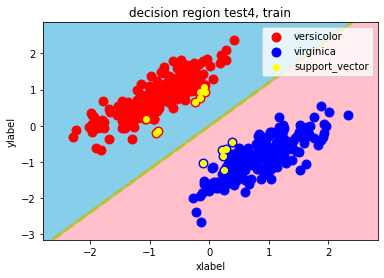

In [ ]:
decision_region(X_train_std,
                y_train,
                test4,
                test4.X_sv,
                title='decision region {}, {}'.format('test4', 'train'))

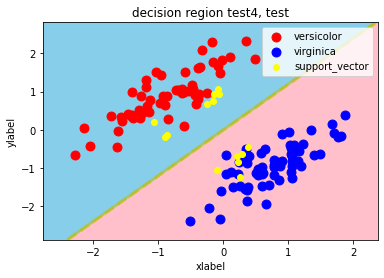

In [ ]:
decision_region(X_test_std,
                y_test,
                test4,
                test4.X_sv,
                title='decision region {}, {}'.format('test4', 'test'))

## 【問題6】（アドバンス課題）多項式カーネル関数の作成
最初に作成した実装では線形カーネルを使用していました。多項式カーネルにも切り替えられるようにしましょう。


「線形カーネルの式」

$$
k(x_i, x_j) = x_{i}^{T} x_j
$$

「多項式カーネルの式」

$$
k(x_i, x_j) = ({\gamma}x_{i}^{T} x_j + \theta_0)^{d}
$$

$γ, θ_0, d$ はハイパーパラメータです。


線形カーネルは $γ=1, θ_0=0, d=1$の場合の多項式カーネルと等しいと言えます。

In [ ]:
# 多項式で2乗に設定
svc_d_2 = ScratchSVMClassifier(num_iter=30, kernel='polynomial', d=2)

In [ ]:
svc_d_2.fit(X_train_std, y_train)

閾値： 1e-05
サポートベクター（候補）: 個数 375 
 [[ 1.15287010e+00 -6.80683008e-01]
 [-1.76799190e+00  9.55227688e-02]
 [-6.09355122e-01  8.35050044e-01]
 [-5.00817233e-01  1.58273818e+00]
 [-1.21336330e+00  2.33429005e-01]
 [ 8.08382221e-01 -1.18654425e+00]
 [ 2.78801081e-01 -1.12519666e+00]
 [ 8.79294279e-01 -1.22869801e+00]
 [-6.66013376e-01  1.18234082e+00]
 [-7.56207567e-01  8.32089008e-01]
 [-6.26605338e-01  1.17030517e+00]
 [ 3.96597607e-01 -1.28197601e+00]
 [ 1.55323450e+00 -3.09247708e-01]
 [-1.38188415e+00  3.94068848e-01]
 [-1.46225550e+00  5.82411335e-01]
 [ 3.32653447e-01 -1.45321303e+00]
 [ 7.78427879e-01 -7.51282369e-01]
 [ 1.47184513e+00 -2.92090742e-01]
 [-4.52036884e-01  7.57522401e-01]
 [ 3.35408831e-01 -9.76266078e-01]
 [-1.31698308e+00  3.19724455e-01]
 [ 1.82249862e+00 -5.30094172e-01]
 [-1.81374103e+00 -6.75112913e-01]
 [ 1.09041983e+00 -8.78289777e-01]
 [ 3.31787318e-01 -8.27432692e-01]
 [ 6.03686710e-01 -6.88400069e-01]
 [-5.53124334e-02  1.80164981e+00]
 [ 5.22843023e-01 -9.7

acc : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0
confusion matrix 
 [[64  0]
 [ 0 61]]


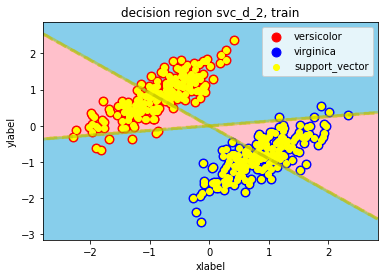

In [ ]:
y_pred = svc_d_2.predict(X_test_std)

evaluate(y_pred, y_test)

decision_region(X_train_std,
                y_train,
                svc_d_2,
                svc_d_2.X_sv,
                title='decision region {}, {}'.format('svc_d_2', 'train'))

多項式（2乗）の場合、全ての学習データがサポートベクターになった。

線がクロスに2本できた。

In [ ]:
# 多項式で3乗に設定
svc_d_3 = ScratchSVMClassifier(num_iter=30, kernel='polynomial', d=3)
svc_d_3.fit(X_train_std, y_train)

閾値： 1e-05
サポートベクター（候補）: 個数 29 
 [[-0.45203688  0.7575224 ]
 [ 0.33178732 -0.82743269]
 [ 0.49934944 -0.61936906]
 [ 0.28427828 -0.63826654]
 [-0.92573734  0.18725791]
 [-0.86606227 -0.1308968 ]
 [-0.10279129 -1.03674538]
 [-0.41012296  0.71369832]
 [ 0.6506986  -0.62050819]
 [ 0.23107827 -0.83592957]
 [ 0.21796862 -0.6728361 ]
 [ 0.82364984 -0.29112421]
 [-0.14991299  0.94242077]
 [ 0.38269934 -0.44719935]
 [-0.9407114   0.18314689]
 [ 0.38472476 -0.7859223 ]
 [-0.93094553  0.17651879]
 [ 0.83614293 -0.23150917]
 [-0.15191629  0.76120219]
 [-0.06630194  0.93690775]
 [ 1.05176788 -0.16724836]
 [-0.89355073 -0.18953236]
 [ 0.90867117 -0.29514115]
 [-0.65318463  0.62467219]
 [ 0.43542707 -0.89146691]
 [ 0.41897102 -0.7671549 ]
 [-0.60864142  0.49450929]
 [-0.24737475  0.67069224]
 [-1.06187284  0.19577049]]


acc : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0
confusion matrix 
 [[64  0]
 [ 0 61]]


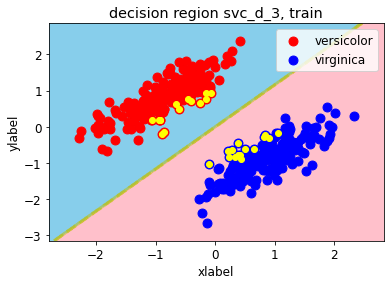

In [ ]:
y_pred = svc_d_3.predict(X_test_std)

evaluate(y_pred, y_test)

decision_region(X_train_std,
                y_train,
                svc_d_3,
                svc_d_3.X_sv,
                title='decision region {}, {}'.format('svc_d_3', 'train'))

線形カーネルよりはサポートベクターの数が増えたがそれ以外は特に変化なし。

In [ ]:
# 多項式で4乗に設定
svc_d_4 = ScratchSVMClassifier(num_iter=30, kernel='polynomial', d=4)
svc_d_4.fit(X_train_std, y_train)

閾値： 1e-05
サポートベクター（候補）: 個数 335 
 [[-1.76799190e+00  9.55227688e-02]
 [-6.09355122e-01  8.35050044e-01]
 [-5.00817233e-01  1.58273818e+00]
 [-1.21336330e+00  2.33429005e-01]
 [ 8.08382221e-01 -1.18654425e+00]
 [ 2.78801081e-01 -1.12519666e+00]
 [ 8.79294279e-01 -1.22869801e+00]
 [-6.66013376e-01  1.18234082e+00]
 [-7.56207567e-01  8.32089008e-01]
 [-6.26605338e-01  1.17030517e+00]
 [ 3.96597607e-01 -1.28197601e+00]
 [ 1.55323450e+00 -3.09247708e-01]
 [-1.38188415e+00  3.94068848e-01]
 [-1.46225550e+00  5.82411335e-01]
 [ 3.32653447e-01 -1.45321303e+00]
 [ 7.78427879e-01 -7.51282369e-01]
 [ 1.47184513e+00 -2.92090742e-01]
 [-4.52036884e-01  7.57522401e-01]
 [ 3.35408831e-01 -9.76266078e-01]
 [-1.31698308e+00  3.19724455e-01]
 [ 1.82249862e+00 -5.30094172e-01]
 [-1.81374103e+00 -6.75112913e-01]
 [ 3.31787318e-01 -8.27432692e-01]
 [ 6.03686710e-01 -6.88400069e-01]
 [-5.53124334e-02  1.80164981e+00]
 [ 5.22843023e-01 -9.73264568e-01]
 [ 8.15912490e-01 -6.97990195e-01]
 [ 9.22046018e-01 -8.8

acc : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0
confusion matrix 
 [[64  0]
 [ 0 61]]


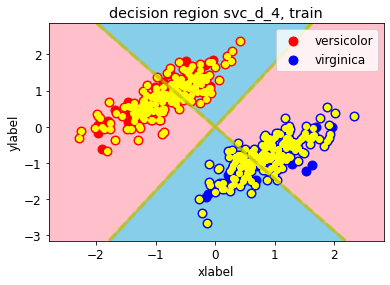

In [ ]:
y_pred = svc_d_4.predict(X_test_std)

evaluate(y_pred, y_test)

decision_region(X_train_std,
                y_train,
                svc_d_4,
                svc_d_4.X_sv,
                title='decision region {}, {}'.format('svc_d_4', 'train'))

2乗の時と似た結果になった。

混合行列にFalseがないので分離できてるということは、分離できていない方の線（分布の上を通っている線）は別次元にある、ということなのか。。。

そもそも、多次元で決定領域を見たい場合は、この決定領域の関数とは別のものが必要になるのではないかと思った。

# 感想
課題をこなすことに頭がいっぱいで、自分なりの考察などがあまりできなかった。他の生徒のソースコードを見ると多項式カーネルの問題で、ハイパラメータdと出力の結果を考察していたのですごいと思った。

# エクストラ
できるだけサポートベクターの数を減らしてみる。

In [ ]:
svc_d_5 = ScratchSVMClassifier(num_iter=25, lr=1e-1)
svc_d_5.fit(X_train_std, y_train)

閾値： 1e-05
サポートベクター（候補）: 個数 9 
 [[ 0.28427828 -0.63826654]
 [-0.86606227 -0.1308968 ]
 [-0.10279129 -1.03674538]
 [ 0.21796862 -0.6728361 ]
 [ 0.38269934 -0.44719935]
 [-0.15191629  0.76120219]
 [-0.06630194  0.93690775]
 [-0.89355073 -0.18953236]
 [-0.24737475  0.67069224]]


イテレーション25、学習率0.1で10切った。

In [ ]:
svc_d_6 = ScratchSVMClassifier(num_iter=66, lr=1e-1)
svc_d_6.fit(X_train_std, y_train)

閾値： 1e-05
サポートベクター（候補）: 個数 7 
 [[-0.86606227 -0.1308968 ]
 [-0.10279129 -1.03674538]
 [ 0.21796862 -0.6728361 ]
 [ 0.38269934 -0.44719935]
 [-0.15191629  0.76120219]
 [-0.89355073 -0.18953236]
 [-0.24737475  0.67069224]]


7個まで少なくなった。